# Comparing Fisher information to MCMC for posterior inference:

In [9]:
import jax.numpy as jnp
import jax
import numpy as np
import matplotlib.pyplot as plt


jax.config.update("jax_enable_x64", True)
jax.config.update('jax_disable_jit', True)


import arviz as az
import paths
from chainconsumer import ChainConsumer


from eclipsoid.light_curve import legacy_oblate_lightcurve
legacy_oblate_lightcurve = jax.jit(legacy_oblate_lightcurve)

In [10]:
import zodiax as zdx
from eclipsoid.utils import zero_safe_arctan2

class OblateTransitModel(zdx.Base):
    period: jnp.ndarray
    t0: jnp.ndarray
    r_circ: jnp.ndarray
    u: jnp.ndarray
    bo: jnp.ndarray
    duration: jnp.ndarray
    t: jnp.ndarray
    h: jnp.ndarray
    k: jnp.ndarray
    f: jnp.ndarray
    theta: jnp.ndarray
    
    def __init__(self, period, t0, r_circ, u, h, bo, k, duration, t):
        self.period = period
        self.r_circ = r_circ
        self.t0 = t0
        self.u = u
        self.h = h
        self.bo = bo
        self.k = k
        self.duration = duration
        self.t = t
        self.f = (self.h**2 + self.k**2)/2.
        self.theta = zero_safe_arctan2(self.k,self.h)/2.
        
    def model(self):
      f = (self.h**2 + self.k**2)/2.
      theta = zero_safe_arctan2(self.k,self.h)/2.
      #Compute a limb-darkened light curve using starry
      params = {'period':self.period,
                't0':self.t0,
                'radius':jnp.sqrt(self.r_circ**2/(1-f)),
                'u':self.u,
                'f':f,
                'bo':self.bo,
                'theta':theta,
                'duration': self.duration
        }
      lc = legacy_oblate_lightcurve(params,self.t)
      return lc

In [31]:
np.random.seed(11)
t = jnp.linspace(0.9,1.1,1000)

true_params = {'period':7.704045333151538,
               't0':1.0,
          'radius':0.1446,
          'u':np.array([0.3,0.2]),
          'f':0.1,
          'bo':0.8,
          'theta':np.radians(35),
          'duration': 0.12
}
yerr = 10*1e-6

data = jnp.array(legacy_oblate_lightcurve(true_params, t-true_params['t0'])+yerr*np.random.normal(size=len(t)))
h = 2*jnp.sqrt(true_params['f']/2)*np.cos(2*true_params['theta'])
k = 2*jnp.sqrt(true_params['f']/2.)*np.sin(2*true_params['theta'])
model = OblateTransitModel(true_params['period'], true_params['t0'], true_params['radius']*jnp.sqrt((1-true_params['f'])), true_params['u'], h, true_params['bo'], k, true_params['duration'], t-true_params['t0'])

In [32]:
def custom_loglike(model, data, noise):
    sigma2 = noise**2
    return 0.5*np.sum((data - model.model()) ** 2 / sigma2)

In [33]:
custom_loglike(model, data, yerr)

Array(508.07004622, dtype=float64)

In [34]:
opt_params = ['h','k', 'r_circ', 'bo', 'duration','u']

cov = zdx.covariance_matrix(model, opt_params, custom_loglike, data, noise=yerr)

In [35]:
inf_data = az.from_netcdf(paths.data / "average_radius_NUTS_10ppm.h5")

In [36]:
h, k = np.concatenate(inf_data.posterior.hk.to_numpy(), axis=0).T
r_circ = np.concatenate(inf_data.posterior.r_circ.to_numpy(), axis=0)
bo = np.concatenate(inf_data.posterior.bo.to_numpy(), axis=0)
duration = np.concatenate(inf_data.posterior.duration.to_numpy(), axis=0)
u1, u2 = np.concatenate(inf_data.posterior.u.to_numpy(), axis=0).T

/Users/uqsdhola/Projects/oblate-planets-paper/.snakemake/conda/98533105bd8a81aae9f47a06dae83721_/lib/python3.9/site-packages/chainconsumer/chainconsumer.py:346: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  chain = np.random.multivariate_normal(mean, covariance, size=1000000)


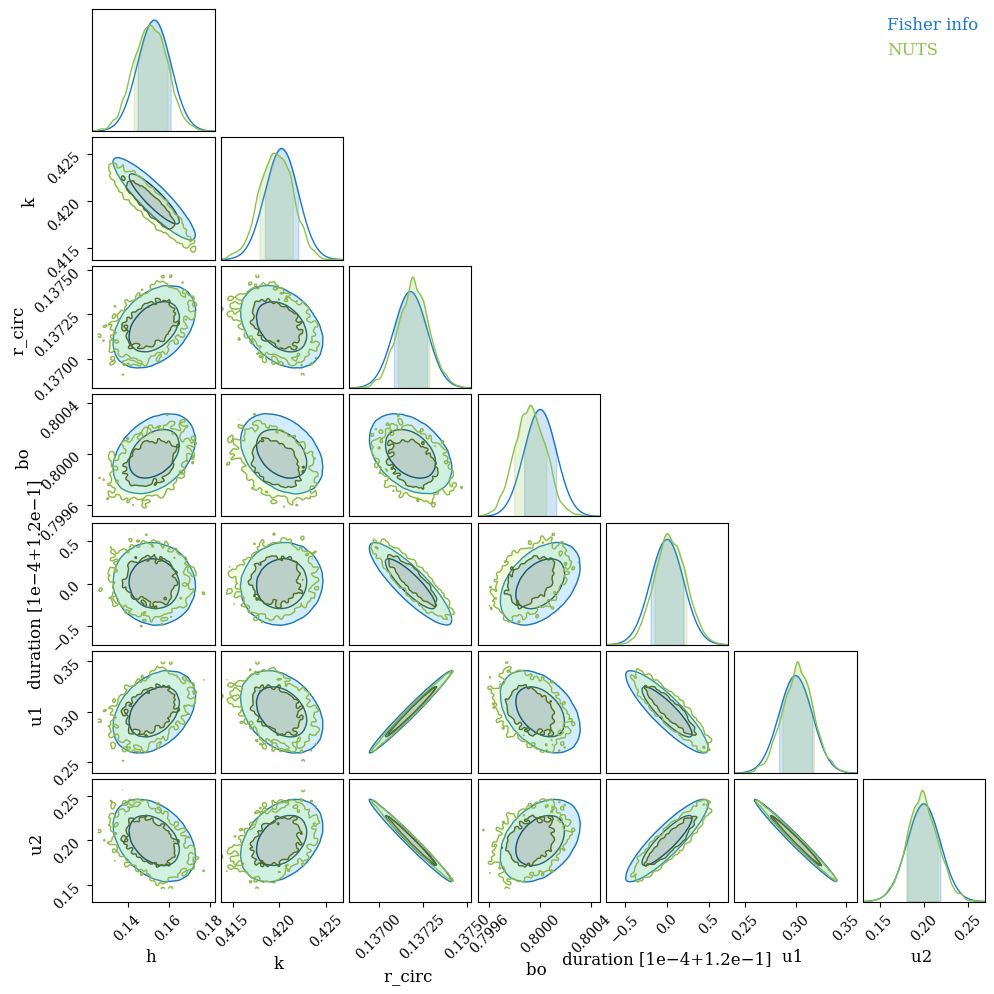

In [37]:
X = np.array([model.h,model.k, model.r_circ, model.bo, model.duration, model.u[0],model.u[1]])
c = ChainConsumer()
c.add_covariance(X, cov, parameters=['h','k', 'r_circ', 'bo', 'duration','u1','u2'], name='Fisher info')
c.add_chain(np.array([h,k,r_circ,bo,duration,u1, u2]).T, parameters=['h','k', 'r_circ', 'bo', 'duration','u1','u2'],name='NUTS')
c.configure(serif=True, shade=True, bar_shade=True, shade_alpha=0.2, spacing=1., max_ticks=3)
fig = c.plotter.plot()